## Compute BER/FER as a function of Eb/N0
A common way for validating a communication chain is to compute Bit Error Rates or Frame Error Rates as a function of SNR (here we choose the SNR per information bit named Eb/N0). This operation includes most of the operations performed in the first part of this tutorial.

So we first specify the vector of Eb/N0 values that we want to consider and convert these values to `sigma` values.

## Build and bind the communication chain

Here, we use the same chain as the previous tutorial 16-QAM + Repetition code

In [39]:
import sys  
sys.path.insert(0, '../../build/lib')
import numpy as np
import time
import matplotlib.pyplot as plt
import math

import py_aff3ct

K   = 2048   # Message size in bits
N   = 4096   # Packet length in bits
bps = 4      # Bits per Symbols   
Ns  = N//bps # Packet size in symbols

src  = py_aff3ct.module.source.Source_random           (K      ) # Build source
enc  = py_aff3ct.module.encoder.Encoder_repetition_sys (K,N    ) # Build the encoder
cstl = py_aff3ct.tools.constellation.Constellation_QAM (bps    ) # Setup constellation tool
mdm  = py_aff3ct.module.modem.Modem_generic            (N, cstl) # Build the modem
chn  = py_aff3ct.module.channel.Channel_AWGN_LLR       (2*Ns   ) # Build the channel (Ns complex symbols = 2Ns real dims)
dec  = py_aff3ct.module.decoder.Decoder_repetition_std (K,N    ) # Build the decoder
mnt  = py_aff3ct.module.monitor.Monitor_BFER_AR        (K,100  ) # Build the monitor (counting errors)

enc[      'encode::U_K' ] = src[   'generate::U_K' ] # Source       -> Encoder
mdm[    'modulate::X_N1'] = enc[     'encode::X_N' ] # Encoder      -> Modulation
chn[   'add_noise::X_N' ] = mdm[   'modulate::X_N2'] # Modulation   -> Channel
mdm[  'demodulate::Y_N1'] = chn[  'add_noise::Y_N' ] # Channel      -> Demodulation
dec[ 'decode_siho::Y_N' ] = mdm[ 'demodulate::Y_N2'] # Demodulation -> Decoder
mnt['check_errors::U'   ] = src[   'generate::U_K' ] # Source       -> Monitor
mnt['check_errors::V'   ] = dec['decode_siho::V_K' ] # Decoder      -> Monitor

sigma = np.ndarray(shape = (1,1),  dtype = np.float32)
sigma[0] = 0.05
# sigma_vals = 1/(math.sqrt(2) * 10 ** (esn0 / 20))

chn[ 'add_noise::CP'].bind(sigma)
mdm['demodulate::CP'].bind(sigma)


## Set variables for the BER/FER loop

In [43]:

ebn0_min = 0
ebn0_max = 12.0
ebn0_step = 0.5

ebn0 = np.arange(ebn0_min,ebn0_max,ebn0_step)
esn0 = ebn0 + 10 * math.log10(K/Ns)
sigma_vals = 1/(math.sqrt(2) * 10 ** (esn0 / 20))

fer = np.zeros(len(ebn0))
ber = np.zeros(len(ebn0))


# Simulation loop

We loop over all `sigma` values and execute each `task` of the chain. The monitor is reset each time to reset the error counter. Once the execution is over, we simply store the monitor BER and FER.

In [44]:
print(" Eb/NO (dB) | Frame number |    BER   |    FER   |  Tpt (Mbps)")
print("------------|--------------|----------|----------|------------")
for i in range(len(sigma_vals)):
	# reset the error counter of the monitor
	mnt.reset()
	# set the new sigma value
	sigma[:] = sigma_vals[i]

	# get the current time
	t = time.time()

	# execute the chain until the error counter reaches the max frame error target : 100 frame errors
	while not mnt.is_done():
		src['generate'    ].exec()
		enc['encode'      ].exec()
		mdm['modulate'    ].exec()
		chn['add_noise'   ].exec()
		mdm['demodulate'  ].exec()
		dec['decode_siho' ].exec()
		mnt['check_errors'].exec()

	# calculate the simulation throughput
	elapsed = time.time() - t
	total_fra = mnt.get_n_analyzed_fra()
	tpt = total_fra * K * 1e-6/elapsed

	# store the current BER and FER values
	ber[i] = mnt.get_ber()
	fer[i] = mnt.get_fer()

	# Display data
	print("%11.2f | %12d | %7.2e | %7.2e | %10.2f"%(ebn0[i], total_fra, ber[i], fer[i], tpt))

 Eb/NO (dB) | Frame number |    BER   |    FER   |  Tpt (Mbps)
------------|--------------|----------|----------|------------
       0.00 |          100 | 1.50e-01 | 1.00e+00 |       1.10
       0.50 |          100 | 1.38e-01 | 1.00e+00 |       1.11
       1.00 |          100 | 1.27e-01 | 1.00e+00 |       1.16
       1.50 |          100 | 1.14e-01 | 1.00e+00 |       1.15
       2.00 |          100 | 1.02e-01 | 1.00e+00 |       1.17
       2.50 |          100 | 9.04e-02 | 1.00e+00 |       1.16
       3.00 |          100 | 8.07e-02 | 1.00e+00 |       1.17
       3.50 |          100 | 6.98e-02 | 1.00e+00 |       1.17
       4.00 |          100 | 5.98e-02 | 1.00e+00 |       1.20
       4.50 |          100 | 5.08e-02 | 1.00e+00 |       1.19
       5.00 |          100 | 4.22e-02 | 1.00e+00 |       1.21
       5.50 |          100 | 3.47e-02 | 1.00e+00 |       1.21
       6.00 |          100 | 2.82e-02 | 1.00e+00 |       1.21
       6.50 |          100 | 2.23e-02 | 1.00e+00 |       1.20
      

## Display the BER/FER curve

Finally we display the BER/FER vs Eb/N0 curves using `matplotlib`

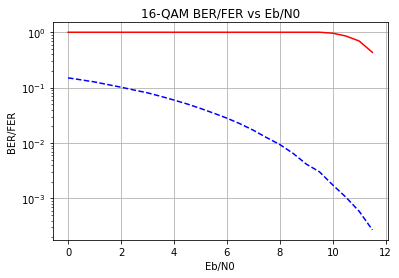

In [45]:
fig = plt.figure()
plt.title("16-QAM BER/FER vs Eb/N0")
plt.xlabel("Eb/N0")
plt.ylabel("BER/FER")
plt.grid()
plt.semilogy(ebn0, fer, 'r-', ebn0, ber, 'b--')
plt.show()


# Exercise

Try to change the modulation constellation and plot the new curve.